# Final Project Report - W205, Fall 2021

# Twitter Streaming

## A real-time data streaming pipeline for querying and vizualizing tweets



### - Heesuk Jang, Devashish Kulkarni, Matt Whittaker, Mili Gera


## Motivation

Twitter is an online news and social networking site where people communicate in short messges called tweets. Twitter boasts approximately 400 million users, of which 75% are based outside of the US<sup>[1]</sup>. As such, users post tweets on various topics, ranging from politics, lifestyle, memes and so on. Twitter is also often used by users to voice opinions and share information regarding ongoing events like sports games, political events and even protests. This digital infrastructure of twitter creates enormous amounts of data that contains invaluable information and insights. However, the task to collect, filter and analyze data from twitter is a difficult one and requires setting up a data pipeline using several state-of-the-art technologies that are capable of handling data at a large scale.

Specifically, this project focuses on collecting tweet data related to climate change. Climate change is a very important topic in today's politics, both in the US and around the world. It is potentially the biggest existential challenge that humans have ever faced. In addition, it is also a controvertial topic, with ideas for addressing it ranging from fundamental tranformation of world economies to completely ignoring it. Hence, understanding what people are saying about climate change could be of interest to political parties, environmental groups and corporations. This project seeks to build a pipeline that would receive streaming data from twitter API related to climate change in real-time, transform it appropriately and store it for further analysis. The analysis of the twitter data in the project seeks to asnwer the following questions related to climate change:

- What are the most frequently used words in the entire set of tweets?
- What are the frequently used words in the top 100 most retweeted tweets?
- What are the top 5 most active usernames?
- What are the top 5 most trending hastags?
- What are the top 10 most retweeted tweets?
- What fraction of retweets, likes and replies are from tweets with a URL in them, compared to tweets without a URL?
- What fraction of retweets, likes and replies are from tweets with a hashtag, compared to tweets without a hashtag?
- What percentage of tweets contain the hastags happeningnow or happening?



## Description of the Data

The data is received using an API provided by twitter<sup>[2]</sup>. Before gaining access to the API, one needs to apply for a developer account with twitter, which includes providing information on the intended use of the data from the Twitter API. Once a developer account is approved, an authentication token is provided to the user. The connection to the twitter stream is established using a specific URL. The stream is specified using two parameters, namely, rules and fields. Rules are used to filter tweets, such that the data received through the stream is particularly applicable for a specific application. Some example rules could be tweets containing a specific phrase, tweets from specific accounts, tweets containing specific hashtags, tweets containing images or links and tweets that are not retweets. Any of these rules can be combined using boolean operators. Multiple separate rules can also be provided. Each separate rule is assigned an ID and each tweet in the data stream contains information about the rules it satifies, allowing for possibilities of interesting analyses.

The other parameter that specifies a data stream is fields. Fields are the specific attributes of a tweet object that are requested in the stream. By default, each tweet in the data stream contains a tweet ID and the text of the tweet. In addition, numerous other fields can be requested, such as, ID and username of the author of the tweet, ID's and usernames of other users tagged in the tweet, location of the tweet, type of device used to send the tweet, time of creating of the tweet, metrics like likes, retweets, comments on the tweet and any attachments like images or videos attached to the tweet. Each tweet is received in a nested JSON format with different levels for tweet data, user data and matching rules.

## Description of the Pipeline

The `docker-compose.yml` file contains information required to spin up each of the containers. The first image is a **Zookeeper** image that works with kafka to track the status of nodes in the Kafka cluster and maintain a list of kafka topics and messages. The second image is **Kafka**, which is the broker that can receive messages produced by a producer and store them in a topic. We use only 1 broker, 1 partition and no replications for this image. We chose the topic name climateChange because we are interested in tweets related to climate change. The next image is **Cloudera** which is ecosystem that lets us use hadoop and HDFS to store the data. We use **Spark** as the service to consume the messages, and it depends on the cloudera image so that we can save data in HDFS as tables in parquet format. We use **Presto** to query the tables stored in HDFS. Finally, the last image is the **MIDS** container which is a ubuntu machine used to mirror the host machine.

`Stream_Filtered_Tweets_from_TwitterAPI.py` is the python script used to specify rules and fields for the twitter stream, connect to the API and log the messages received from the API to kafka using a Kafka Producer. An authentication code is required to connect to the twitter and receive data. To receive the code, a user must first apply for a developer account at the [twitter developer portal](developer.twitter.com). Three levels of developer accounts are available, namely, 'Essential', 'Elevated and 'Academic Research', each with an increasing level of access to the data. For this project, we applied for the most basic 'Essential' version. The application needs to include the core use case, intent, or business purpose for the use of the Twitter APIs. If any analysis of Tweets, Twitter users, or their content is intended to be performed, details about the analyses that are planned, and the methods or techniques need to be shared. Once a developer account is approved, the user receives a *Bearer Token* that serves as the authentication code to connect to the twitter API. The `Stream_Filtered_Tweets_from_TwitterAPI.py` script receives the Bearer Token as an environmental variable from the operating system. This is enabled by created a hidden .env file where the Bearer token is assigned to a *BEARER_TOKEN* variable. This files is not shared publicly for security purposes. In addition, this python script also specifies the rules and fields for the twitter stream. A combination of multiple rules is used, such that the data stream receives tweets that include the phrase 'climate change', include specific hashtags (for example #climatechange, #HappeningNow) or are created by specific twitter accounts (for example @ClimateChangeAI, @ClimateChangeG2). The data fields requested from the tweets include the tweet ID, tweet text, author information (such as user ID, user name and location) and engagement metrics (such as likes, retweets and replies).

`ETL_withSpark_and_Write_to_Hadoop.py` is the python script that runs a spark job to consume the messages from the kafka topic in a streaming fashion, transform them to a spark data frame using a forced schema and write both the raw data and the transformed data tables to HDFS as parquet files. The forced schema unrolls the messages received in a nested JSON format into columns for each of the data fields that were requested from the twitter API. in addition, this script also contains functions to extract hashtags and URLs from the tweet text and adds those as additional columns to the hadoop table. Since we only have access to the Essential developer account, there is a limit to the number of tweets that can be received which is capped at 500,00 per month. The topic of climate change is very popular on twitter, and hence this limit can be reached fairly quickly if the pipeline is run in a streaming fashion for some time. For the purpose of this project, we programmatically limit the number of tweets to ~3000 and send those through the data pipeline. The analystics are then performed on the data tables generated from these tweets.

We use hive to create an external table that can be queried using Presto. This is implemented in `Querying_Data_using_Presto.ipynb` jupyter notebook. This notebook establishes a connection between the Presto container and port 8880 on the localhost, i.e. the host machine on google cloud platform. Port 8880 on localhost redirects to port 8080 inside the Presto container; this connection is established in the docker-compose.yml file. For the presto connection, we specify the catalog as 'hive' and the schema as 'default'. This allows us to connect to the data stored in HDFS, which is confirmed by using the show tables command; we see the external table that was created in Hive. We use Pandas to convert the table into a Pandas DataFrame and use this to create vizualizations that aid in answering the business questions that motivate this project.

## Procedure to build the Pipeline

The follwing commands are used to spin up the data pipeline described above.

    docker-compose down     
    #Ensure that all containers are torn down before we start
    
    docker-compose up -d    
    #Spin up all the containers requried for the pipeline
    
    docker-compose exec kafka kafka-topics  --create  --topic climateChange  --partitions 1  --replication-factor 1  --if-  not-exists  --zookeeper zookeeper:32181   
    #Create kafka topic called climateChange
    
    docker-compose exec mids bash -c "python3 /w205/Final_Project_Gera_Whittaker_Kulkarni_Jang/heesukj_KafkaProducer_Twitter_Filtered_Stream.py"    
    #Run python script to connect to twitter API and send the received data to kafka producer
    
    docker-compose exec mids bash -c "kafkacat -C -b kafka:29092 -t climateChange -o beginning -e"
    #(optional) Sanity check to ensure message are logged in kafka
    
    docker-compose exec spark spark-submit /w205/Final_Project_Gera_Whittaker_Kulkarni_Jang/heesukj_write_tweets_stream.py
    #Run spark job to consume messages from kafka, transform into spark dataframes and save to HDFS as parquet files
    
    docker-compose exec cloudera hadoop fs -ls /tmp/
    # (optional) Sanity check to ensure the data is stored correctly in HDFS
    
   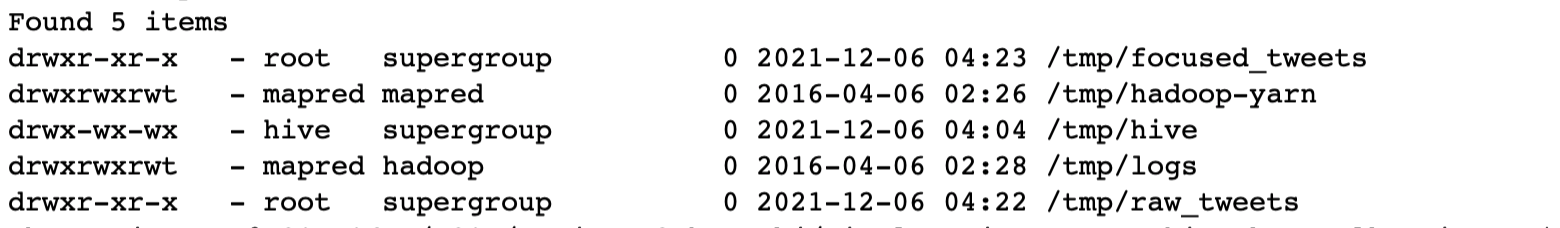
    
    docker-compose exec cloudera hive    
    #Execute hive
    
    #In the hive command line, Create external talbes that can be queried using Presto
    hive> create external table if not exists default.focused_tweets_forquery (    
    > author_id string,
    > tweet_id string,
    > tweet_created_at string,
    > retweet_count int,
    > reply_count int,
    > like_count int,
    > user_location array<string>,
    > user_fullname array<string>,
    > username array<string>,
    > tweet_text string,
    > hashtag_name array<string>,
    > url array<string>
    >)
    > stored as parquet
    > location '/tmp/focused_tweets/'
    > tblproperties ("parquet.compress"="SNAPPY");
    "

## Findings

The code used to create the vizualizations can be found in `heesukj_querying_Presto.ipynb`. Some interesting insights can be gathered from these, which are dicussed below.

- To look at the most common words used in tweets related to climate change, we create a wordcloud with the 2967 tweets received from the twitter API. As expected, the words 'climate change' seem to be the most common, because this is the phrase we use to filter the tweets. 'Global warming' is also a phrase specified in one of the rules used in the stream and appears quite frequently. Some other interesting high frequency words include 'solution', 'protect', 'world', 'confident', and 'nature'. These words are likely to appear in tweets that emphasise the importance of acting to mitigate the effects of climate change as a way of protecting the planet. Another interesting group of words with lower frequency include 'oil' and  'carbon'. These indicate tweets that mention fossil fuels as the cause of climate change. 

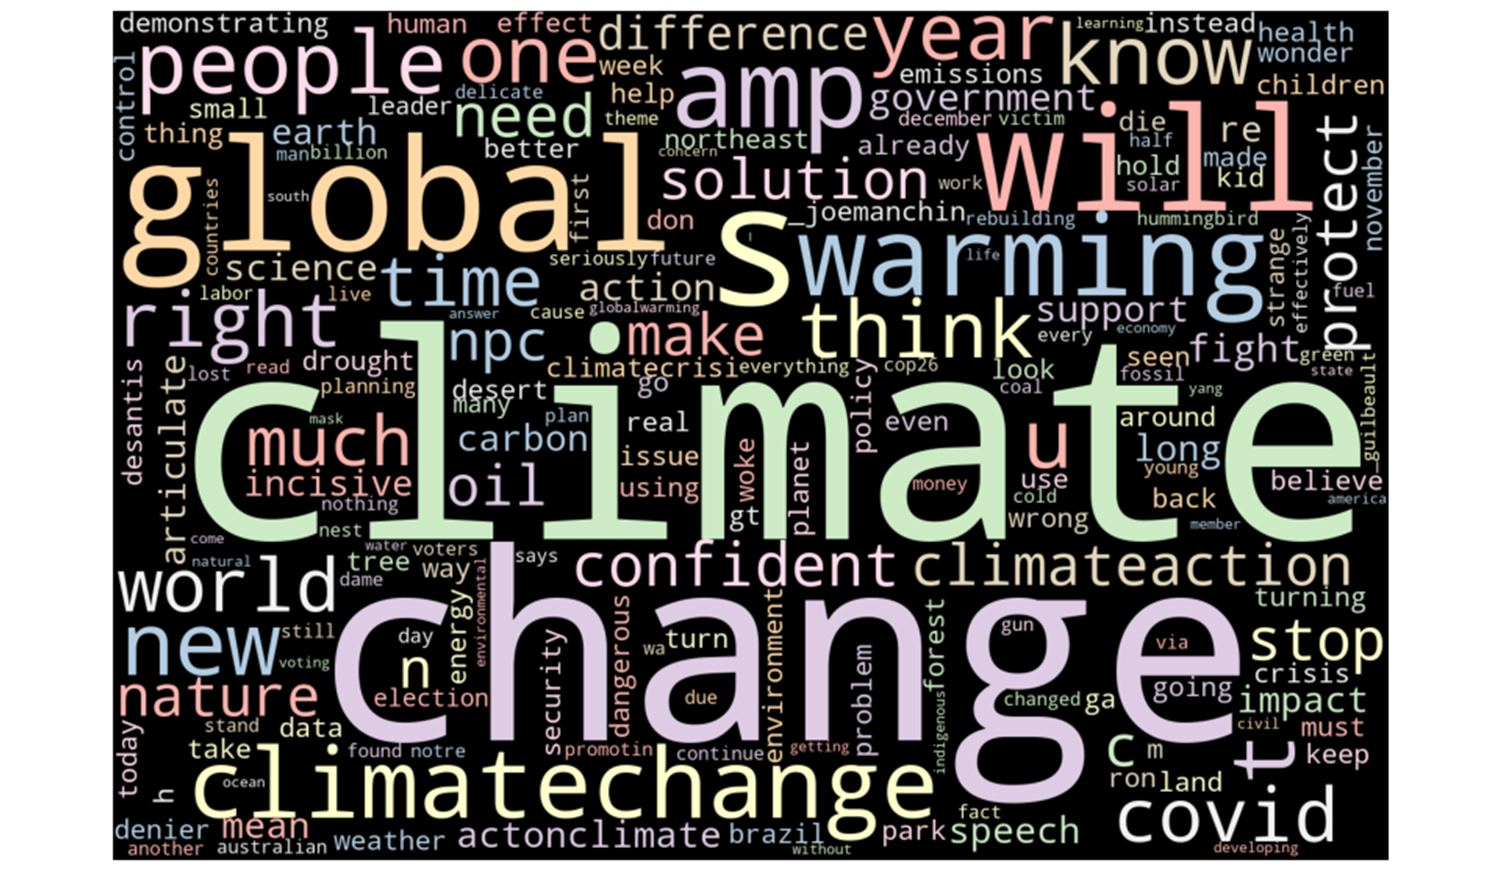

- Looking at the most common words used in the top 100 retweeted tweets, we see an inetersting result that the words likely to appear in the most 'viral' tweets are pretty different from the words in the entire set of tweets. Words like 'oil', 'gas', 'government', 'officials', 'suspended', 'greenland and 'exploration' appear in this set which point to tweets that talk about specific actions or policies adopted by governments or other agencies.

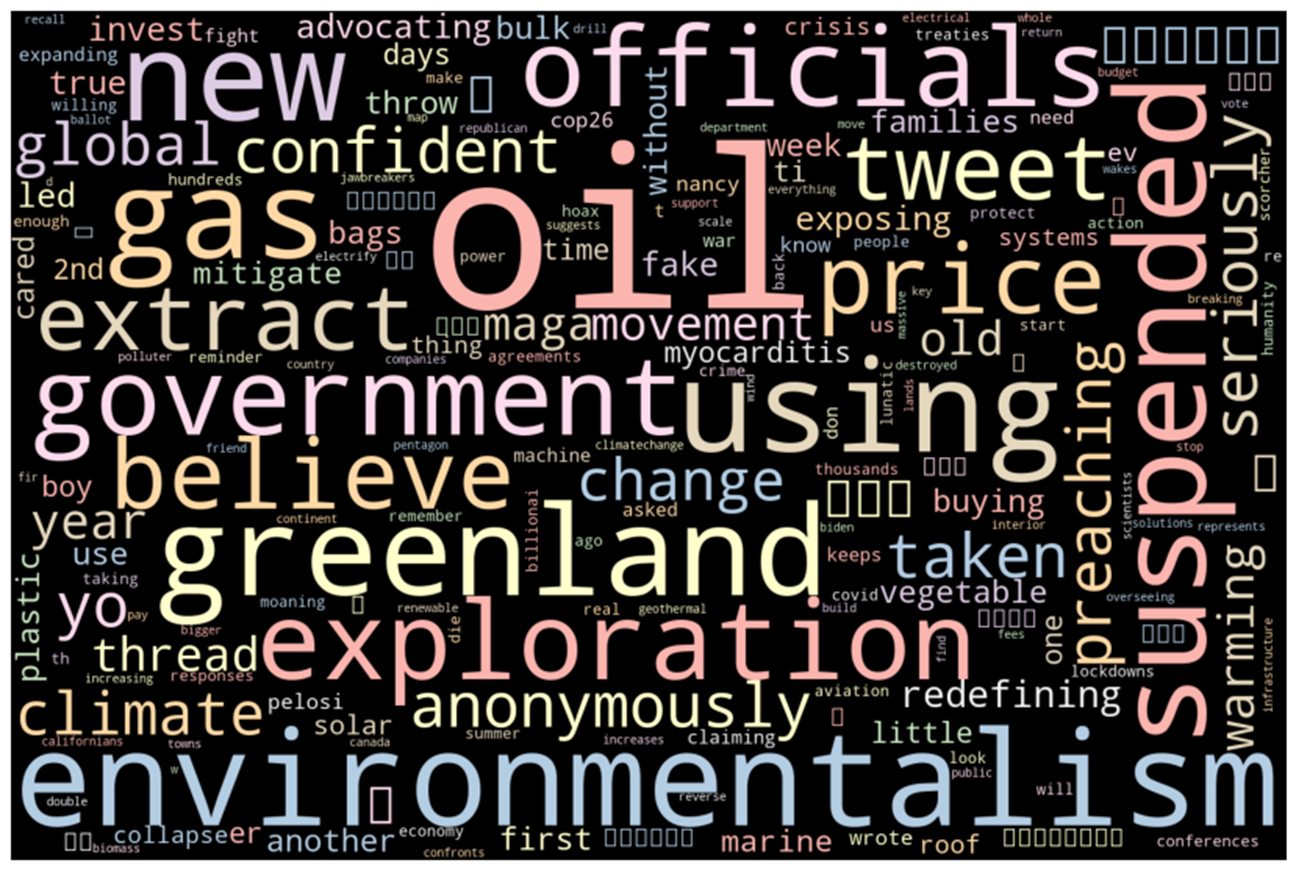

- Looking at the most active accounts that post tweets related to cliamte change, we see accounts that belong to private users. Interestingly, the maximum number of tweets by an account is 21, which is ~0.007% of the total number of tweets used in this analysis.

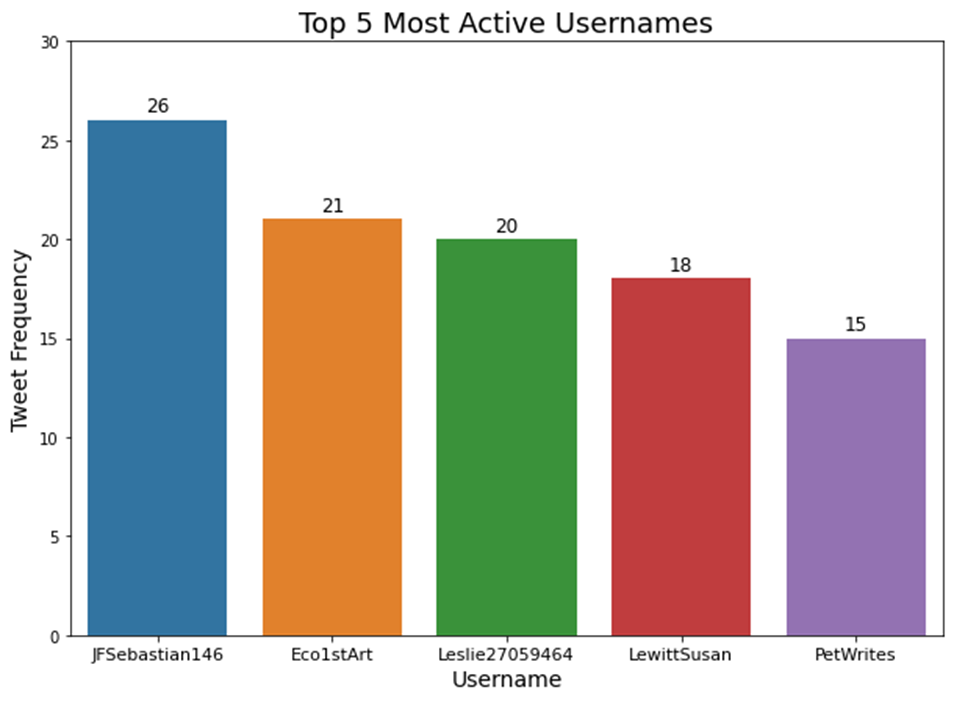

- Looking at the top 5 hashtags used in this group of tweets, we see #climatechange having the highest frequency by far. #climateaction and #actonclimate are the two next most frequently used hashtags and are ones that can be though to promote action. The fifth most used hashtag is #climatecrisis, which can be interpreted as a more alarming hastag.

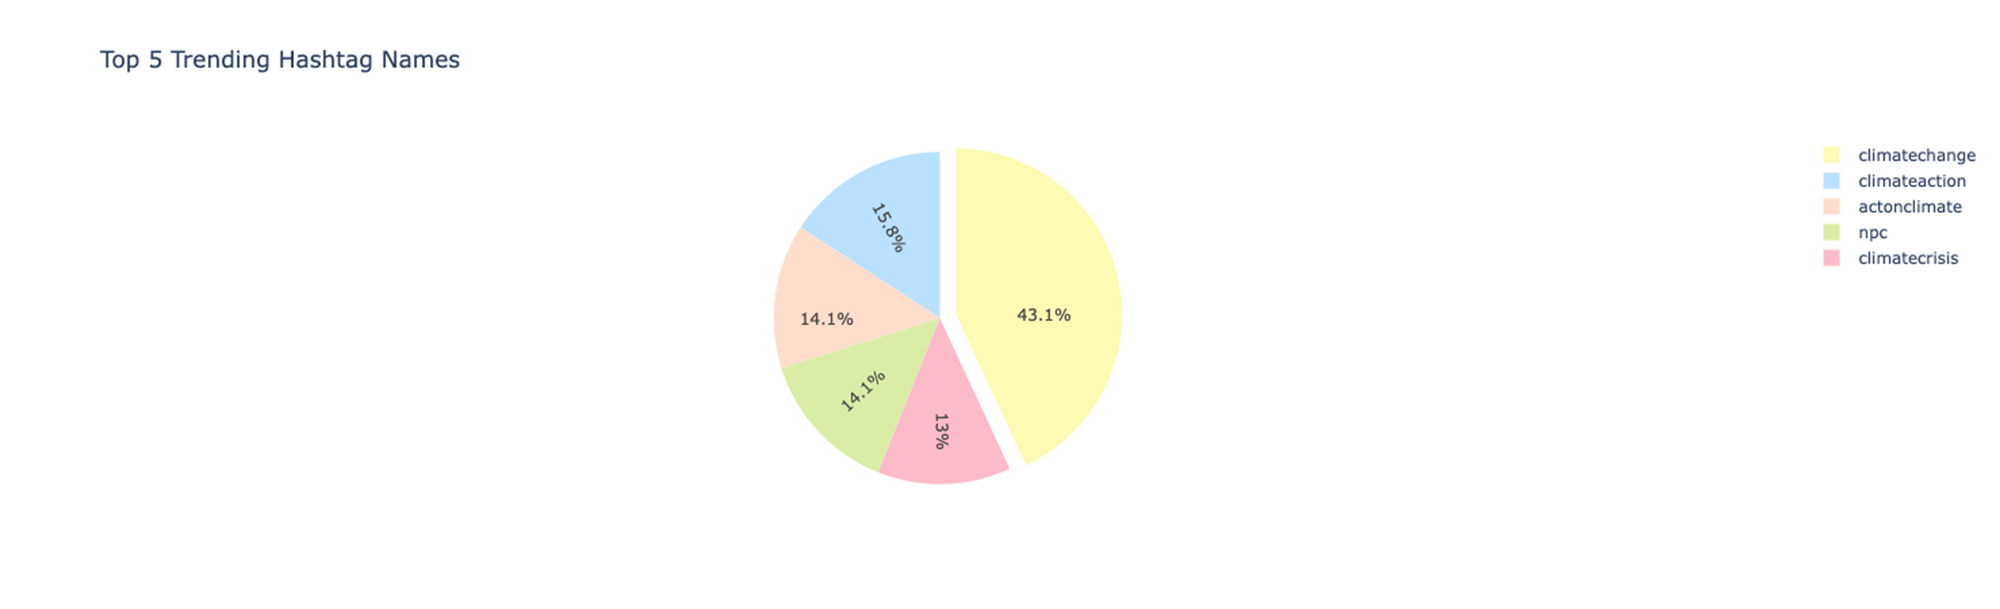

- The top 10 tweets with the most retweets is in the table below. We see that some tweets appear multiple times in the table as a tweet is repeatedly retweeted. Most of the tweets are retweets of prominent figures in the climate movement and in society such as Greta Thunberg and Stacy Abrams.

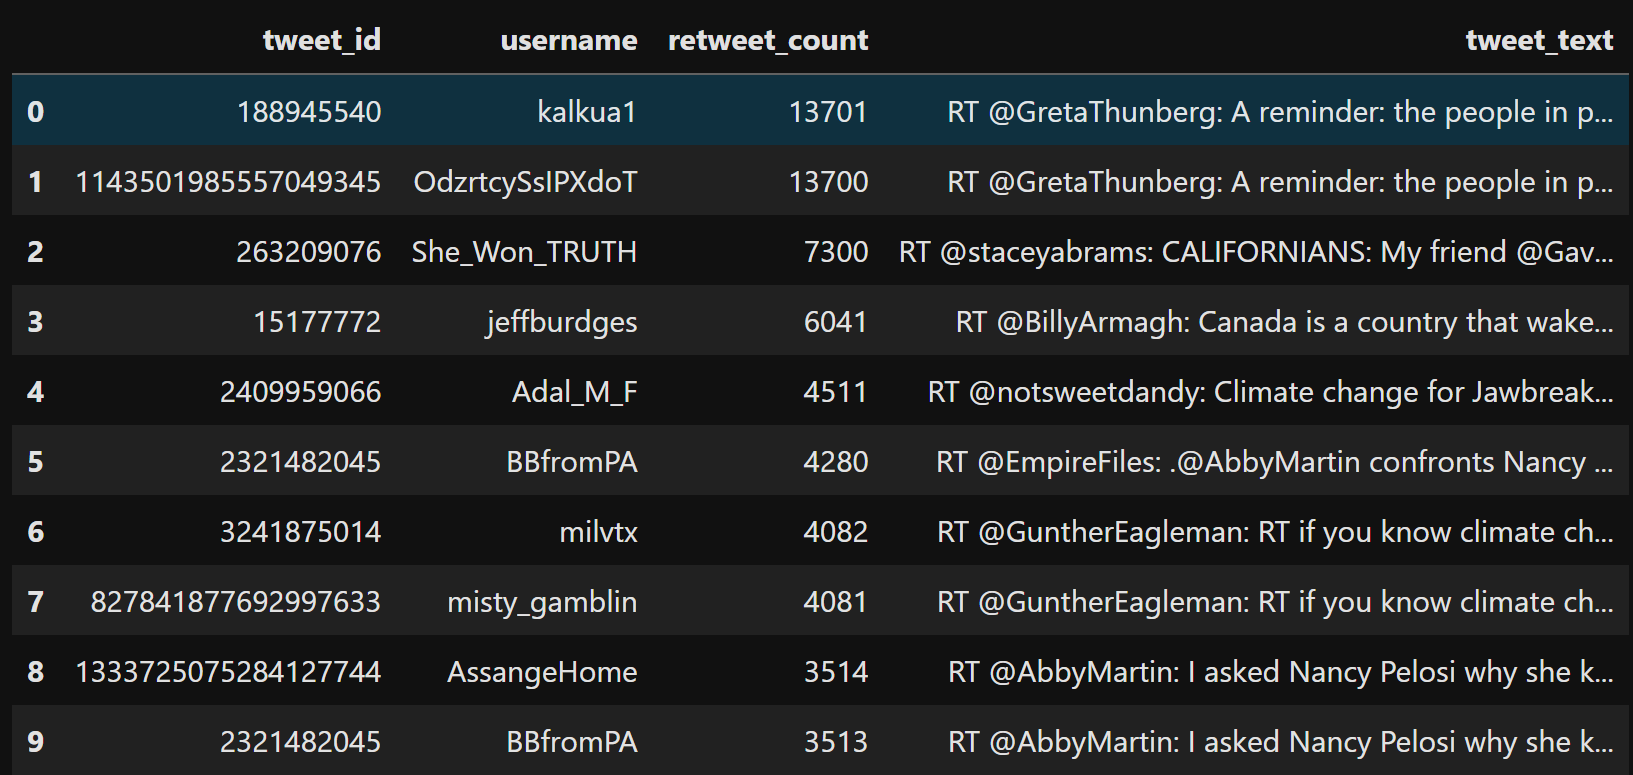


- In our sample dataset, we saw tweets which did not have url links were replied-to and retweeted at a higher frequency than those which did have a url.  There was an estimated 77% difference in the reply rate for tweets without urls versus those with urls. In addition, there was an estimated 83% difference in the retweet rate for tweets without urls versus those with urls. In contrast, we observed that the like count for tweets with urls was 15% higher than those without urls.

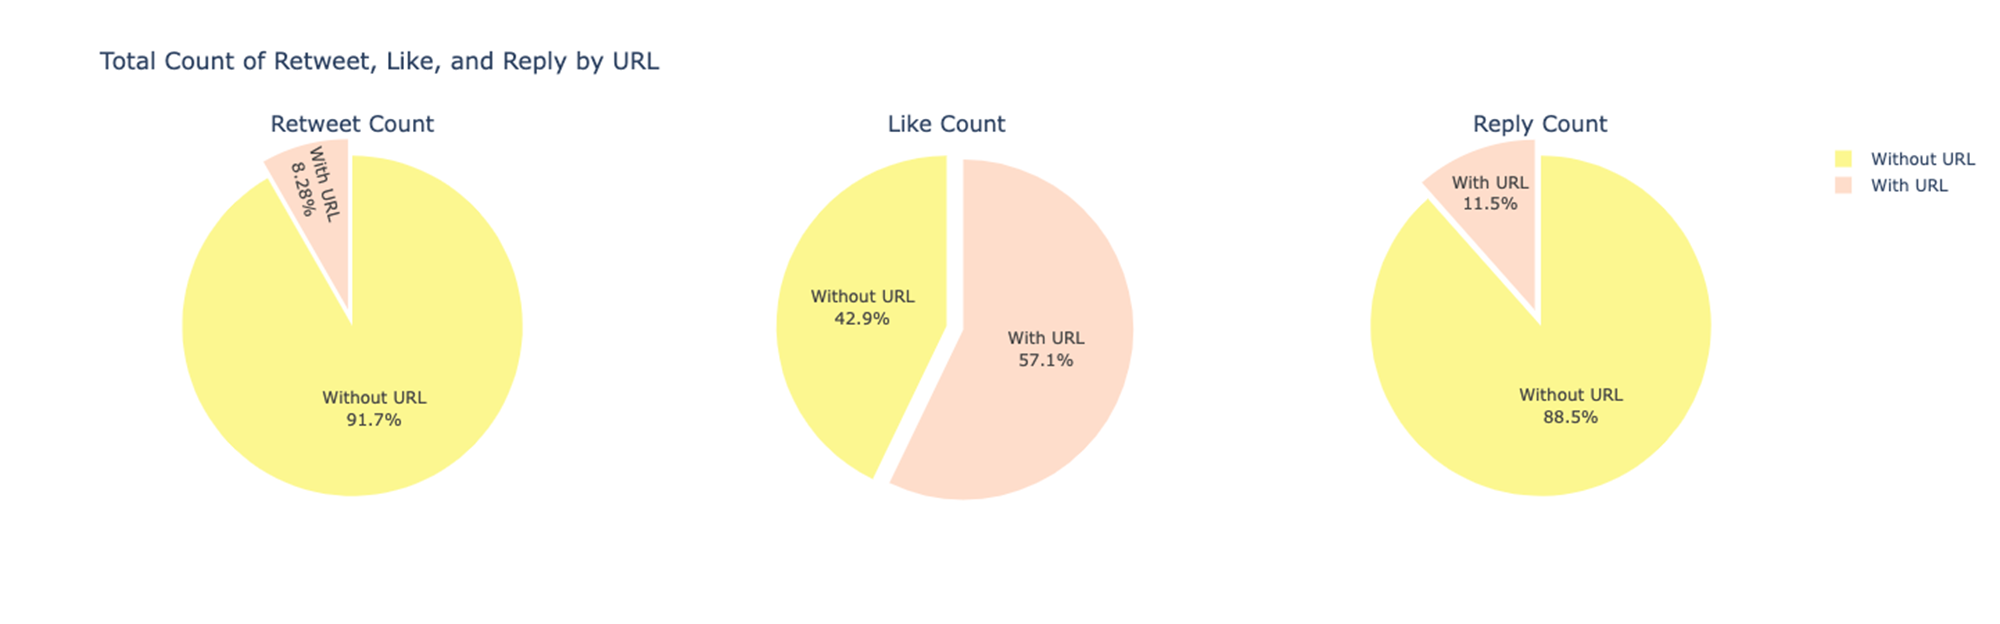

- Our observations using our sample dataset for tweets with or without hashtags were as follows: tweets without hashtags were retweeted, like and replied-to at higher rates that tweets with hashtags. There was a 56% difference in retweet rate, a 43% difference in like counts, and a 100% difference in reply counts for tweets without hashtags versus those with hashtags.

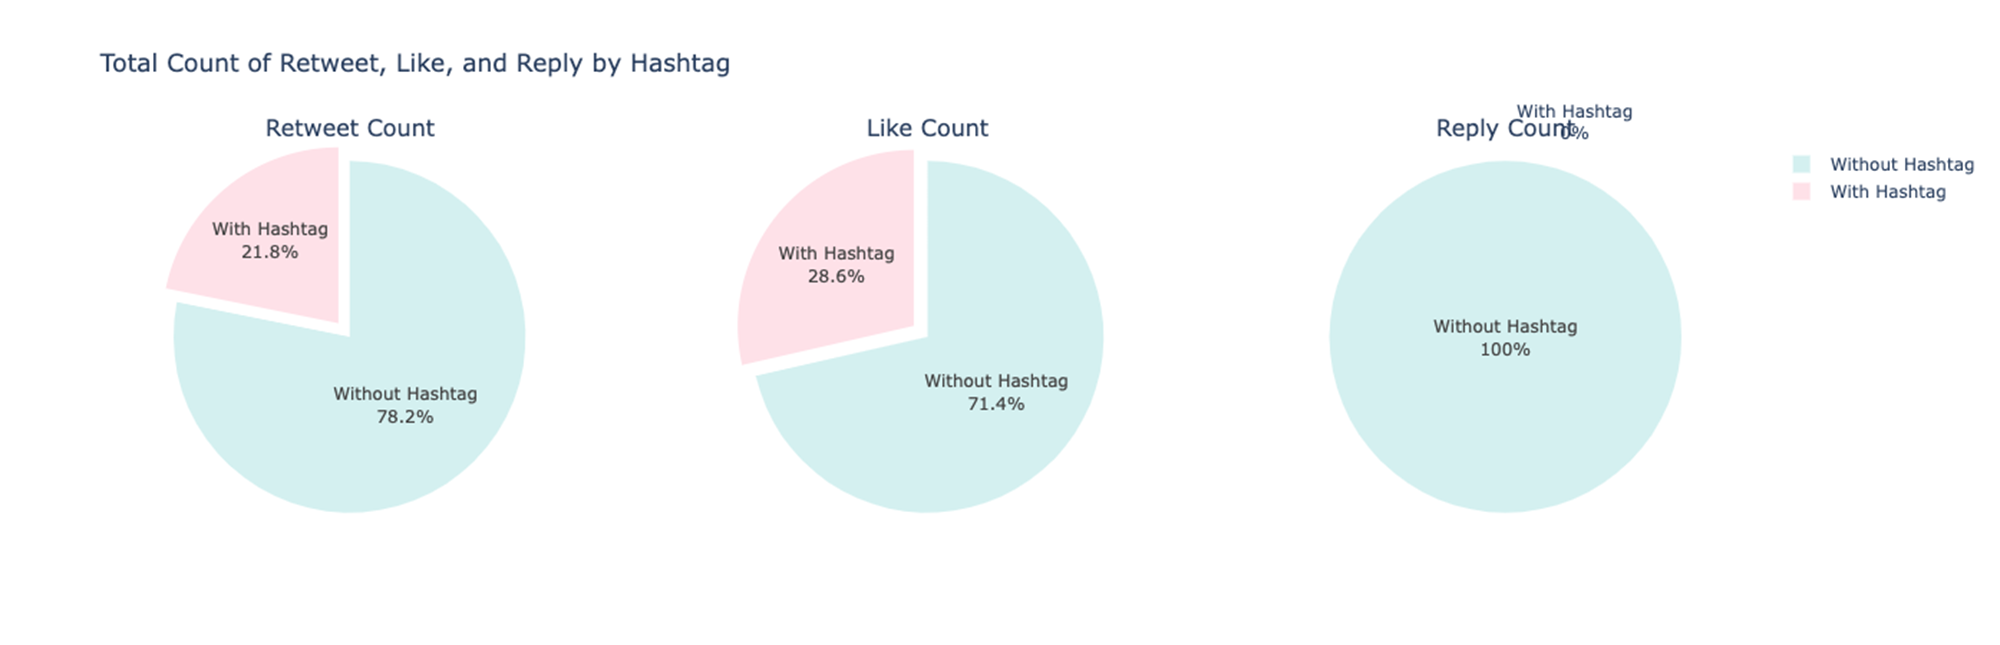

## Conclusions

In the course of this project, we have built a data pipeline that is capable to receving tweet data from twitter API. Specifically, we capture tweets related to climate change and use Kafka, Spark, Hadoop and Presto as the tools to construct the pipeline, where each of the tools is spun up as a container using docker-compose. The pipeline is capable of receiving tweets in real-time in streaming fashion from the creation of the tweets on twitter upto storing the tweet data into HDFS as a table. By querying the table, we are able to create vizualizations that aid in answering the business questions that motivate this project.


## References

[1] https://backlinko.com/twitter-users#twitter-statistics

[2] https://developer.twitter.com/en/docs